### Week_Three_Assignment

In [4]:
import sklearn

In [5]:
# . Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
from sklearn.datasets import make_moons
# Make 1000 samples 
n_samples = 1000
# Create circles
X, y = make_moons(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [6]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[-0.00933187  0.39098105]
 [ 0.95457387 -0.47375583]
 [ 0.9185256  -0.42519648]
 [ 0.41276802 -0.37638459]
 [-0.84532016  0.52879908]]

First 5 y labels:
[1 1 1 1 0]


In [7]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [9]:
 # Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [10]:
# 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
from torch import nn
class Make_MoonsV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_0 = Make_MoonsV1().to(device)
print(model_0)

Make_MoonsV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [11]:
# 3. Setup a binary classification compatible loss function and optimizer to use when training the model.
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [12]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [13]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.71918, Accuracy: 50.00% | Test loss: 0.71413, Test acc: 50.00%
Epoch: 100 | Loss: 0.48456, Accuracy: 80.75% | Test loss: 0.49914, Test acc: 80.50%
Epoch: 200 | Loss: 0.29773, Accuracy: 86.25% | Test loss: 0.30395, Test acc: 86.50%
Epoch: 300 | Loss: 0.22899, Accuracy: 88.75% | Test loss: 0.22972, Test acc: 90.00%
Epoch: 400 | Loss: 0.19269, Accuracy: 91.12% | Test loss: 0.19654, Test acc: 91.00%
Epoch: 500 | Loss: 0.15890, Accuracy: 93.12% | Test loss: 0.16060, Test acc: 92.50%
Epoch: 600 | Loss: 0.11800, Accuracy: 95.12% | Test loss: 0.11590, Test acc: 96.50%
Epoch: 700 | Loss: 0.07749, Accuracy: 97.75% | Test loss: 0.07364, Test acc: 98.00%
Epoch: 800 | Loss: 0.04934, Accuracy: 99.50% | Test loss: 0.04507, Test acc: 99.50%
Epoch: 900 | Loss: 0.03269, Accuracy: 99.75% | Test loss: 0.02908, Test acc: 100.00%


In [15]:
import matplotlib.pyplot as plt
from helper_functions import plot_predictions, plot_decision_boundary

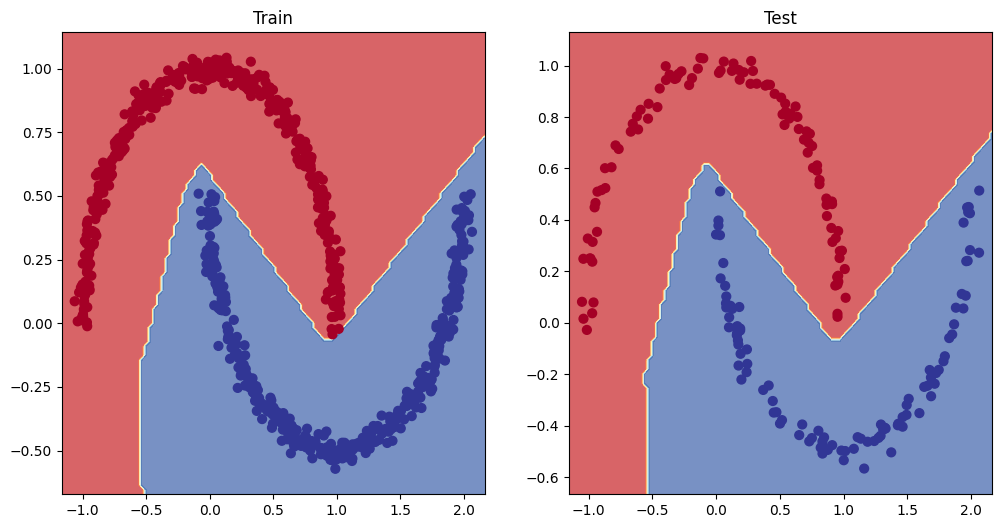

In [17]:
# Plot decision boundaries for training and test sets
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [18]:
# 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
import torch
from sklearn.datasets import make_moons
from torch import nn

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_moons(n_samples, noise=0.03, random_state=42)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
print(X[:5], y[:5])



tensor([[-0.0093,  0.3910],
        [ 0.9546, -0.4738],
        [ 0.9185, -0.4252],
        [ 0.4128, -0.3764],
        [-0.8453,  0.5288]]) tensor([1., 1., 1., 1., 0.])


In [19]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [20]:
class Make_MoonsV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=100)
        self.layer_2 = nn.Linear(in_features=100, out_features=100)
        self.layer_3 = nn.Linear(in_features=100, out_features=1)
        self.tanh = nn.Tanh()  # Use Tanh activation function

    def forward(self, x):
        x = self.tanh(self.layer_1(x))
        x = self.tanh(self.layer_2(x))
        x = self.layer_3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1 = Make_MoonsV2().to(device)
print(model_1)

Make_MoonsV2(
  (layer_1): Linear(in_features=2, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=1, bias=True)
  (tanh): Tanh()
)


In [21]:
# 3. Setup a binary classification compatible loss function and optimizer to use when training the model.
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
# loss_fn = nn.CrossEntropyLoss() # BCEWithLogitsLoss = sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)


In [22]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [23]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.71394, Accuracy: 51.38% | Test loss: 0.66336, Test acc: 72.00%
Epoch: 100 | Loss: 0.24482, Accuracy: 88.88% | Test loss: 0.24374, Test acc: 89.50%
Epoch: 200 | Loss: 0.23204, Accuracy: 89.62% | Test loss: 0.22770, Test acc: 90.50%
Epoch: 300 | Loss: 0.21082, Accuracy: 90.75% | Test loss: 0.20539, Test acc: 91.50%
Epoch: 400 | Loss: 0.16519, Accuracy: 93.12% | Test loss: 0.15867, Test acc: 93.00%
Epoch: 500 | Loss: 0.11766, Accuracy: 94.62% | Test loss: 0.11074, Test acc: 95.50%
Epoch: 600 | Loss: 0.08297, Accuracy: 97.50% | Test loss: 0.07642, Test acc: 98.00%
Epoch: 700 | Loss: 0.05943, Accuracy: 98.88% | Test loss: 0.05366, Test acc: 98.50%
Epoch: 800 | Loss: 0.04372, Accuracy: 99.62% | Test loss: 0.03883, Test acc: 100.00%
Epoch: 900 | Loss: 0.03314, Accuracy: 99.75% | Test loss: 0.02907, Test acc: 100.00%


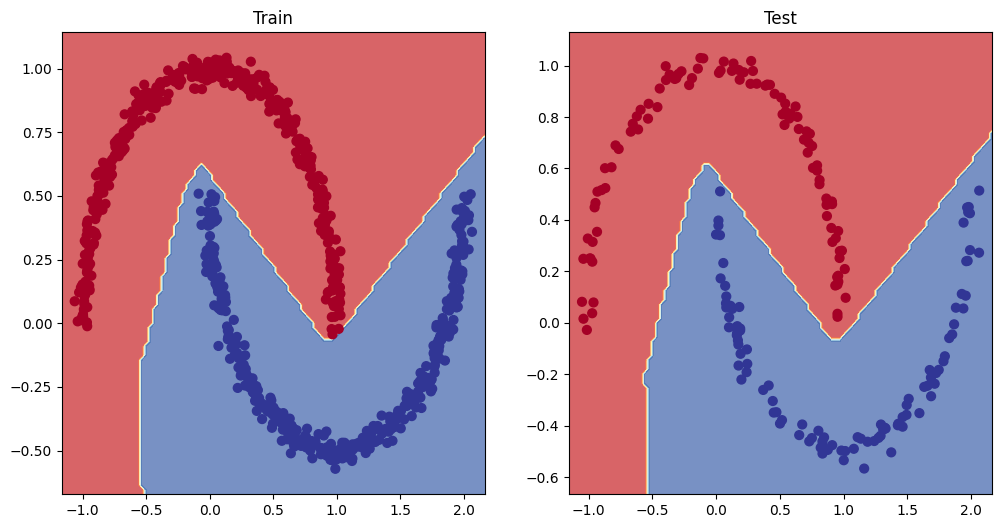

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

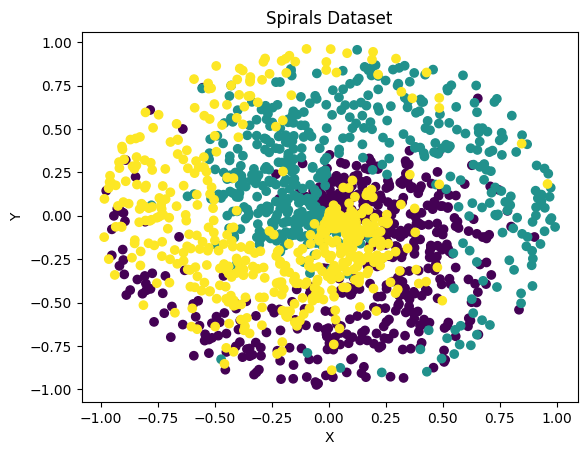

In [25]:
# 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
import numpy as np
import matplotlib.pyplot as plt

def create_spirals_dataset(n_samples, n_classes, noise=0.5):
    """
    Create a multi-class dataset with spirals using the CS231n spirals data creation function.

    Args:
        n_samples (int): Number of samples to generate.
        n_classes (int): Number of classes (spirals) to create.
        noise (float): Amount of noise to add to the data.

    Returns:
        X (numpy.ndarray): Input features of shape (n_samples, 2).
        y (numpy.ndarray): Target labels of shape (n_samples,).
    """
    X = np.zeros((n_samples * n_classes, 2))
    y = np.zeros(n_samples * n_classes, dtype='uint8')
    for j in range(n_classes):
        ix = range(n_samples * j, n_samples * (j + 1))
        r = np.linspace(0.0, 1, n_samples)  # radius
        t = np.linspace(j * 4, (j + 1) * 4, n_samples) + np.random.randn(n_samples) * noise  # theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j
    return X, y

# Example usage:
n_samples = 500
n_classes = 3
noise = 0.8
X, y = create_spirals_dataset(n_samples, n_classes, noise)

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spirals Dataset')
plt.show()

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()



In [27]:
# Define the model architecture
class SpiralModel(nn.Module):
    def __init__(self):
        super(SpiralModel, self).__init__()
        self.fc1 = nn.Linear(2, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = SpiralModel().to(device)
print(model_2)


SpiralModel(
  (fc1): Linear(in_features=2, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
)


In [28]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model_2.parameters(), lr=0.01)
#optimizer2 = optim.SGD(model_2.parameters(), lr=0.001)
#optimizer = optim.Adagrad(model.parameters(), lr=0.01)


In [29]:
def accuracy_fn(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    correct = torch.eq(y_true, predicted).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

In [33]:

torch.manual_seed(42)

# Training loop
n_epochs = 4000

for epoch in range(n_epochs):
    # Zero the gradients
    optimizer2.zero_grad()

    # Forward pass
    y_pred = model_2(X_train)
    loss = loss_fn(y_pred, y_train)
    

# 2. Calculate loss/accuracy
    loss = loss_fn(y_pred, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # Backward pass and optimization
    loss.backward()
    optimizer2.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")

# Evaluate the model on the test set
### Testing
    model_2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_2(X_test)
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_pred,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.07814, Accuracy: 97.17% | Test loss: 3.04147, Test acc: 74.00%
Epoch 100/4000, Loss: 0.09452163428068161
Epoch: 100 | Loss: 0.09437, Accuracy: 96.75% | Test loss: 2.89677, Test acc: 74.67%
Epoch 200/4000, Loss: 0.07937728613615036
Epoch: 200 | Loss: 0.07934, Accuracy: 97.50% | Test loss: 2.95625, Test acc: 74.00%
Epoch 300/4000, Loss: 0.07767106592655182
Epoch: 300 | Loss: 0.07762, Accuracy: 97.42% | Test loss: 3.01441, Test acc: 73.67%
Epoch 400/4000, Loss: 0.07653225213289261
Epoch: 400 | Loss: 0.07655, Accuracy: 97.33% | Test loss: 3.04790, Test acc: 74.00%
Epoch 500/4000, Loss: 0.09410430490970612
Epoch: 500 | Loss: 0.08520, Accuracy: 96.33% | Test loss: 3.09047, Test acc: 74.33%
Epoch 600/4000, Loss: 0.08020244538784027
Epoch: 600 | Loss: 0.08456, Accuracy: 96.58% | Test loss: 3.09688, Test acc: 73.33%
Epoch 700/4000, Loss: 0.07463477551937103
Epoch: 700 | Loss: 0.07576, Accuracy: 97.42% | Test loss: 3.14380, Test acc: 74.00%
Epoch 800/4000, Loss: 0.135299235582

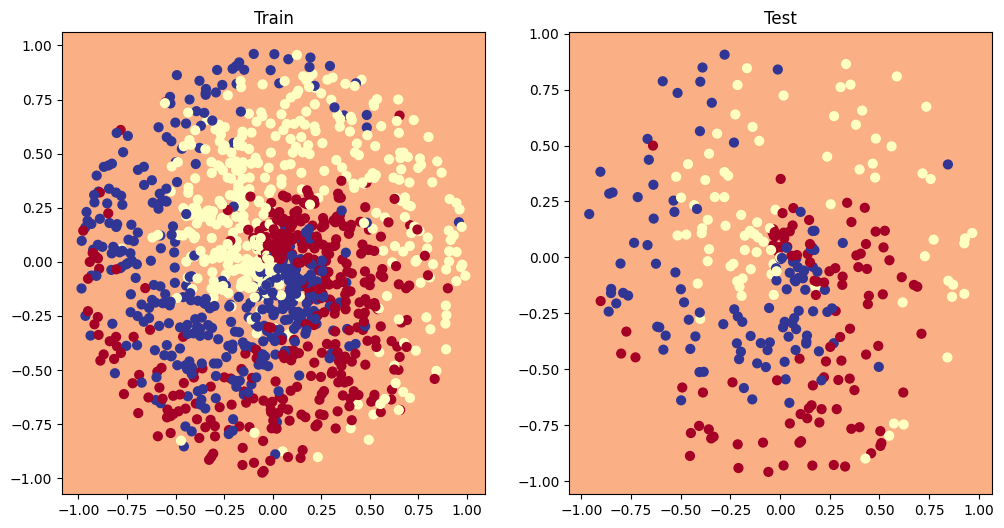

In [34]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)